In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import edward as ed
import numpy as np
import tensorflow as tf

In [2]:
def build_toy_dataset(N, w, noise_std=0.1):
  D = len(w)
  x = np.random.randn(N, D)
  y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
  return x, y

N = 10000  # number of data points
D = 50  # number of features

w_true = np.random.randn(D)
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

We build a toy datasets where the target depends linear on the features.

In [3]:
from edward.models import Normal

X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

In [4]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

#### Question:
Why softplus?

In [5]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=100, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 46s | Loss: 10162.833


In [18]:
inference.loss

<tf.Tensor 'Neg:0' shape=() dtype=float32>

In [7]:
y_post = ed.copy(y, {w: qw, b: qb})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

In [8]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0130354
Mean absolute error on test data:
0.0907416


In [9]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

In [10]:
qw.scale.eval()

array([ 0.0593961 ,  0.06810302,  0.10781081,  0.09441487,  0.09281149,
        0.03014319,  0.0294928 ,  0.02093259,  0.03819047,  0.01342766,
        0.04642209,  0.07414986,  0.05413636,  0.06520656,  0.06255669,
        0.11298346,  0.01944433,  0.03722342,  0.06289504,  0.03151074,
        0.05898048,  0.04502556,  0.04174244,  0.03914651,  0.02739122,
        0.02256724,  0.07292876,  0.03416963,  0.07543039,  0.04386055,
        0.03651866,  0.0239034 ,  0.06349745,  0.02917723,  0.01800456,
        0.08334485,  0.05115312,  0.01085048,  0.04880885,  0.02003387,
        0.10187428,  0.03835305,  0.01056436,  0.06191114,  0.02034451,
        0.07282048,  0.03467271,  0.04034325,  0.07994513,  0.05467454], dtype=float32)

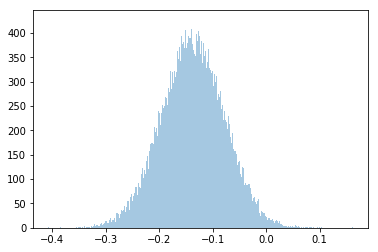

In [11]:
sample = qw.sample(100000).eval()
sns.distplot(sample[:,0], bins=1000, kde=False)

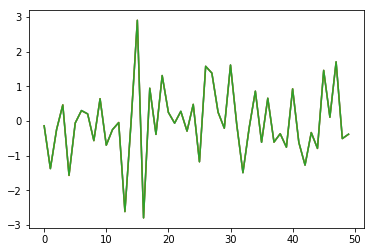

In [12]:
w_est = sample.mean(axis=0)
plt.plot(w_est)
plt.plot(w_true)
plt.plot(qw.loc.eval())

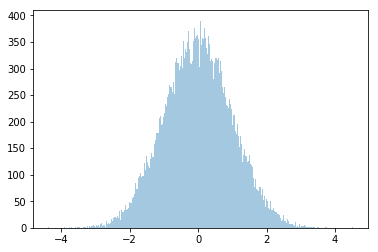

In [13]:
bsample = b.sample(100000)[:, 0].eval()
sns.distplot(bsample, bins=1000, kde=False)

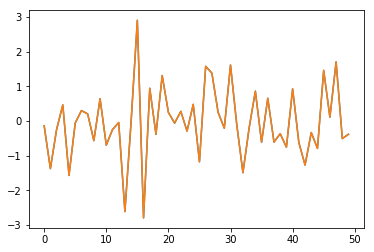

In [14]:
b_est = sample.mean(axis=0)
plt.plot(w_est)
plt.plot(w_true)

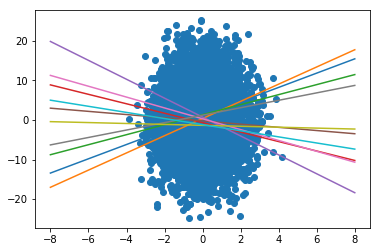

In [15]:
# Visualize samples from the prior.
visualise(X_train, y_train, w, b)

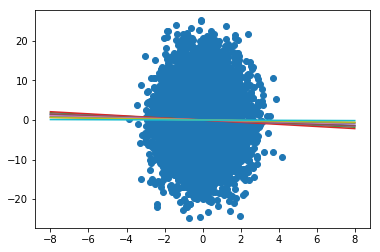

In [16]:
# Visualize samples from the posterior.
visualise(X_train, y_train, qw, qb)